In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import quantile_transform
from umap import UMAP
from matplotlib import pyplot as plt

from tqdm import tqdm
tqdm.pandas()

from one.api import ONE
from brainbox.io.one import SessionLoader
from one.alf.exceptions import ALFObjectNotFound

import sys
sys.path.append('/home/crombie/code/ibl_photometry/src')
# import iblphotometry.loaders as loaders
import iblphotometry.io as io
import iblphotometry.processing as proc
import iblphotometry.pipelines as pipelines
import iblphotometry.metrics as metrics

from util import load_photometry_data, restrict_photometry_to_task

In [2]:
# Load data from fetched sessions
df_sessions = pd.read_parquet('metadata/sessions.pqt')

In [3]:
df_sessions['local_photometry'] = df_sessions['local_photometry'].replace({'nan': False}).astype(bool)
alf_datasets = ['alf/photometry/photometry.signal.pqt', 'alf/photometry/photometryROI.locations.pqt']
df_sessions['remote_photometry'] = df_sessions.apply(lambda x: all([x[dset] for dset in alf_datasets]), axis='columns')

In [4]:
def _get_regions(series, df_regions=None):
    assert df_regions is not None
    eid = series['eid']
    region = df_regions.query('eid == @eid')
    series['ROI'] = region['ROI'].to_list()
    return series

df_regions = pd.read_csv('metadata/regions.csv')
df_sessions = df_sessions.apply(_get_regions, df_regions=df_regions, axis='columns')  # .explode('ROI')

In [5]:
# df = df_sessions.query('local_photometry == True or remote_photometry == True')
df = df_sessions.query('local_photometry == True')

In [6]:
one_remote = ONE()
one_local = ONE(cache_dir='/home/crombie/mnt/ccu-iblserver')

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/api.py:183: UserWarning: Large cache tables affect performance. Consider removing them by calling the `_remove_table_files` method.
  warnings.warn(


In [31]:
raw_metrics = [
    'n_unique_samples',
    'n_spikes_dt',
    'n_spikes_dy',
    # 'n_outliers',
    'expmax_violation',
    'deviance',
    'bleaching_amp'
]

processed_metrics = [
    'percentile_dist',
    'signal_asymmetry',
    'low_freq_power_ratio',
    'ar_score'
]

behavior_metrics = []

In [8]:
pipeline = [
    (proc.remove_spikes, dict()),
    (proc.exponential_bleachcorrect, dict(correction_method='subtract'))
]

In [9]:
session = df.iloc[0]

In [11]:
metrics_dict = session[['eid', 'subject', 'lab', 'start_time', 'strain', 'NM', 'session_type']].to_dict()
raw_data = load_photometry_data(session, one_remote, one_local)
metrics_dict['dt_violations'] = metrics.dt_violations(raw_data)
metrics_dict['interleaved_acquisition'] = metrics.interleaved_acquisition(raw_data)

In [12]:
t0 = raw_data.index.min()
t1 = raw_data.index.max()
i0 = raw_data.index.searchsorted(t0 - 10 * 60)
i1 = raw_data.index.searchsorted(t1 + 10 * 60)
raw_data = raw_data.iloc[i0:i1].copy()

In [13]:
    photometry = {
        ch: raw_data.query('name == @ch').drop(columns='name') for ch in ['GCaMP', 'Isosbestic']
    }

In [14]:
F = photometry['GCaMP'][session['ROI'][0]]

In [19]:
from iblphotometry.qc import qc_series

In [21]:
sliding_kwargs = {'w_len': 60}

In [36]:
qc_dict = qc_series(F, {getattr(metrics, metric):{} for metric in raw_metrics}, sliding_kwargs=sliding_kwargs)

In [37]:
qc_dict.keys()

dict_keys(['n_unique_samples', 'n_unique_samples_values', 'n_unique_samples_times', 'n_unique_samples_r', 'n_unique_samples_p', 'n_spikes_dt', 'n_spikes_dt_values', 'n_spikes_dt_times', 'n_spikes_dt_r', 'n_spikes_dt_p', 'n_spikes_dy', 'n_spikes_dy_values', 'n_spikes_dy_times', 'n_spikes_dy_r', 'n_spikes_dy_p', 'expmax_violation', 'expmax_violation_values', 'expmax_violation_times', 'expmax_violation_r', 'expmax_violation_p', 'deviance', 'deviance_values', 'deviance_times', 'deviance_r', 'deviance_p', 'bleaching_amp', 'bleaching_amp_values', 'bleaching_amp_times', 'bleaching_amp_r', 'bleaching_amp_p'])

In [ ]:
metrics_dicts = []
for _, session in tqdm(df.iterrows(), total=len(df)):
    metrics_dict = session[['eid', 'subject', 'lab', 'start_time', 'strain', 'NM', 'session_type']].to_dict()
    try:
        raw_data = load_photometry_data(session, one_remote, one_local)
    except ValueError:
        print(f"Unable to load photometry data for {session['eid']}")
        continue
    metrics_dict['dt_violations'] = metrics.dt_violations(raw_data)
    metrics_dict['interleaved_acquisition'] = metrics.interleaved_acquisition(raw_data)
    if session['remote_photometry']:
        try:
            raw_data = restrict_photometry_to_task(session['eid'], raw_data, one_remote)
        except ALFObjectNotFound:
            print(f"No trials found for {session['eid']}")
            continue
    else:
        t0 = raw_data.index.min()
        t1 = raw_data.index.max()
        i0 = raw_data.index.searchsorted(t0 - 10 * 60)
        i1 = raw_data.index.searchsorted(t1 + 10 * 60)
        raw_data = raw_data.iloc[i0:i1].copy()
    photometry = {
        ch: raw_data.query('name == @ch').drop(columns='name') for ch in ['GCaMP', 'Isosbestic']
    }
    for roi in photometry['GCaMP'].columns:
        metrics_dict['roi'] = roi
        for metric in raw_metrics:
            metric_func = getattr(metrics, metric)
            metrics_dict[metric] = metric_func(photometry['GCaMP'][roi])
        proc = pipelines.run_pipeline(pipeline, photometry['GCaMP'][[roi]])
        for metric in processed_metrics:
            metric_func = getattr(metrics, metric)
            metrics_dict[metric] = metric_func(photometry['GCaMP'][roi])
        metrics_dicts.append(metrics_dict)

  7%|███                                       | 65/905 [01:19<14:59,  1.07s/it]

Unable to load photometry data for b0dae33d-ce97-463d-b59d-f60243e03a18


  8%|███▏                                      | 70/905 [01:27<18:19,  1.32s/it]

Unable to load photometry data for 842d7f51-c0e1-4b0d-968e-7a0c25e06c5e


  8%|███▍                                      | 74/905 [01:32<17:15,  1.25s/it]

Unable to load photometry data for 0eb07488-aceb-4ae3-8959-f71770b0decb


  8%|███▍                                      | 75/905 [01:33<14:33,  1.05s/it]

Unable to load photometry data for eda254d7-ff17-47fb-9641-bfd3afecb27f


  9%|███▌                                      | 77/905 [01:33<08:42,  1.59it/s]

Unable to load photometry data for 53cf11cf-030b-4f3d-b8cc-27c506c61e04
Unable to load photometry data for 85914000-ae15-4886-9acb-3cec15c4c052


  9%|███▋                                      | 79/905 [01:33<05:19,  2.59it/s]

Unable to load photometry data for b3408c7b-7ea9-46af-bcaf-a42e5c13cfa5
Unable to load photometry data for e963b780-2d49-481b-9494-6af04ebce5eb


  9%|███▋                                      | 80/905 [01:33<04:10,  3.29it/s]

Unable to load photometry data for 58754e26-f2b6-4633-b5ba-bbe0876c1fec


  9%|███▊                                      | 81/905 [01:35<08:05,  1.70it/s]

Unable to load photometry data for 99187d9c-65a6-46b8-993e-ba12e00b3d5e


 10%|████▏                                     | 90/905 [01:47<20:14,  1.49s/it]/home/crombie/code/ibl_photometry/src/iblphotometry/metrics.py:109: RuntimeWarning: divide by zero encountered in scalar divide
  return a / b
 11%|████▌                                     | 97/905 [02:01<26:07,  1.94s/it]

Unable to load photometry data for 18375258-4210-436e-b47e-6ce6df0b8a47


 12%|████▉                                    | 108/905 [02:18<19:38,  1.48s/it]

Unable to load photometry data for 020474c1-8ed5-4258-9b85-01fd2d59a03e


 12%|█████                                    | 111/905 [02:20<16:00,  1.21s/it]

Unable to load photometry data for 58c01a89-8858-427a-9d2c-aa09313db087


 12%|█████                                    | 113/905 [02:22<12:41,  1.04it/s]

In [6]:
BEHAVIORMETRICS = ['response_variability_ratio', 'response_magnitude']

def _calc_metric(series, metric=None, pipeline=None, one=None, event_name='feedback', trial_filter='feedbackType == 1'):
    """
    Calculate a single metric value for a single row in a dataframe.

    Parameters
    ----------
    series : pd.Series
        A single row of the dataframe.
    metric : str
        The name of the metric to calculate.
    pipeline : object
        The pipeline used to process photometry data.
    one : object
        Object to load datasets like trials.

    Returns
    -------
    float
        The calculated metric value for the row.
    """
    assert metric is not None and pipeline is not None
    kwargs = {}
    if metric in BEHAVIORMETRICS:
        try:
            trials = one.load_dataset(row['eid'], '*trials.table').query(trial_filter)
            kwargs['events'] = trials[f'{event_name}_times']
        except:
            return np.nan
    metric_func = getattr(metrics, metric)
    photometry_proc = pipe.run_pipeline(pipeline, row['photometry_ca'])
    return metric_func(photometry_proc.iloc[:, 0], **kwargs)

In [204]:
pipeline_highpass = [
    # (proc.remove_spikes, dict(sd=5)),
    (
    proc.lowpass_bleachcorrect,
    dict(
        correction_method='subtract',
        filter_params=dict(N=3, Wn=0.01, btype='lowpass'),
        )
    )
]

session = df_trials.query('subject == "ZFM-08689"').iloc[-7]
fig = session_plot(session, pipeline=pipeline_highpass)

IndexError: single positional indexer is out-of-bounds

> /home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/indexing.py(1685)_validate_integer()
   1683         len_axis = len(self.obj._get_axis(axis))
   1684         if key >= len_axis or key < -len_axis:
-> 1685             raise IndexError("single positional indexer is out-of-bounds")
   1686 
   1687     # -------------------------------------------------------------------



ipdb>  c


## For KB data on local server
Need to mount filesystem via ssfs before runnign

In [13]:
metrics.low_freq_power_ratio(photometry_proc['Region4G'])

np.float64(0.7820230766847418)

In [14]:
metrics.spectral_entropy(photometry_proc['Region4G'])

np.float64(0.13827989728381007)

In [15]:
metrics.ar_score(photometry_proc['Region4G'])

np.float64(0.3638413328225682)

In [16]:
noise_sd = np.logspace(-2, 1)
scores = metrics.noise_simulation(photometry_proc['Region4G'], metrics.spectral_entropy, noise_sd)

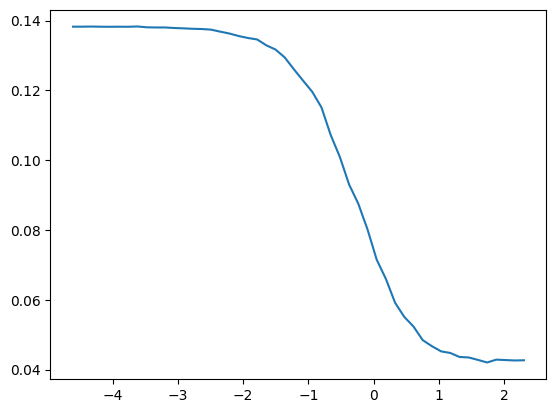

In [17]:
plt.plot(np.log(noise_sd), scores)

In [8]:
# 3 entries are waaaaay out of expected range
df_recordings.loc[df_recordings['response_magnitude'] > 100, 'response_magnitude'] = np.nan

# Move relevant columns to smaller df and drop rows with any NaN values
cols = list(metrics_dict.keys()) + ['subject', 'eid', 'date', 'targeted_regions', 'fiber_diameter_um', 'photometry_ca']
df_metrics = df_recordings[cols]

In [ ]:
df_metrics['

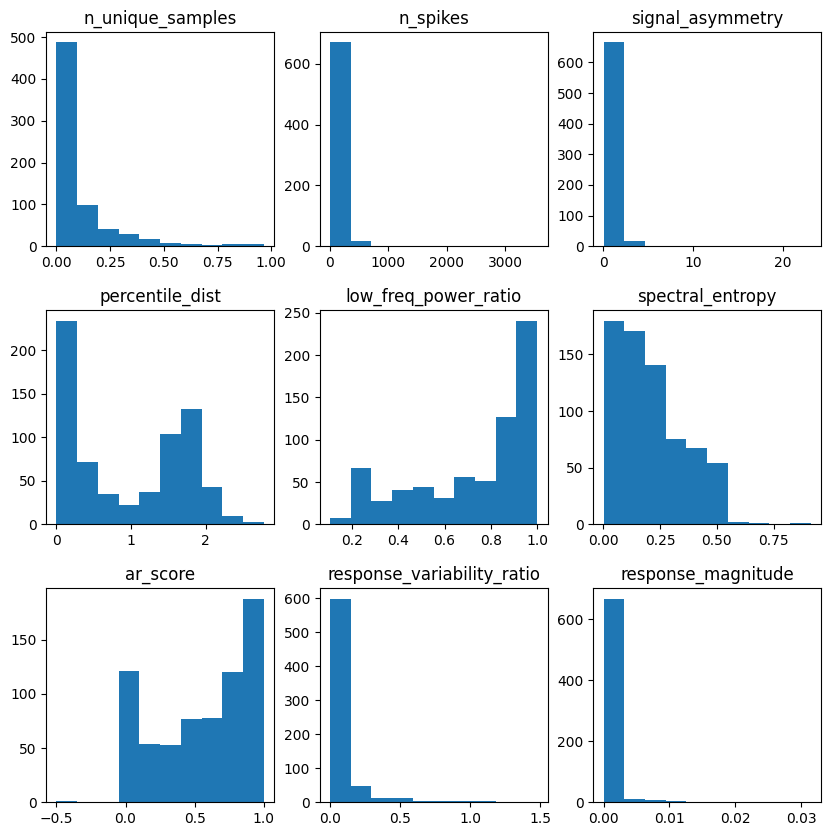

In [110]:
n_metrics = len(metrics_dict.keys())
fig, axs = plt.subplots(int(np.ceil(n_metrics / 3)), 3, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3)
for ax, (metric_name, metric_values) in zip(axs.ravel(), df_metrics[metrics_dict.keys()].items()):
    ax.hist(metric_values.dropna())
    ax.set_title(metric_name)
    

  0%|          | 0/694 [00:00<?, ?it/s]

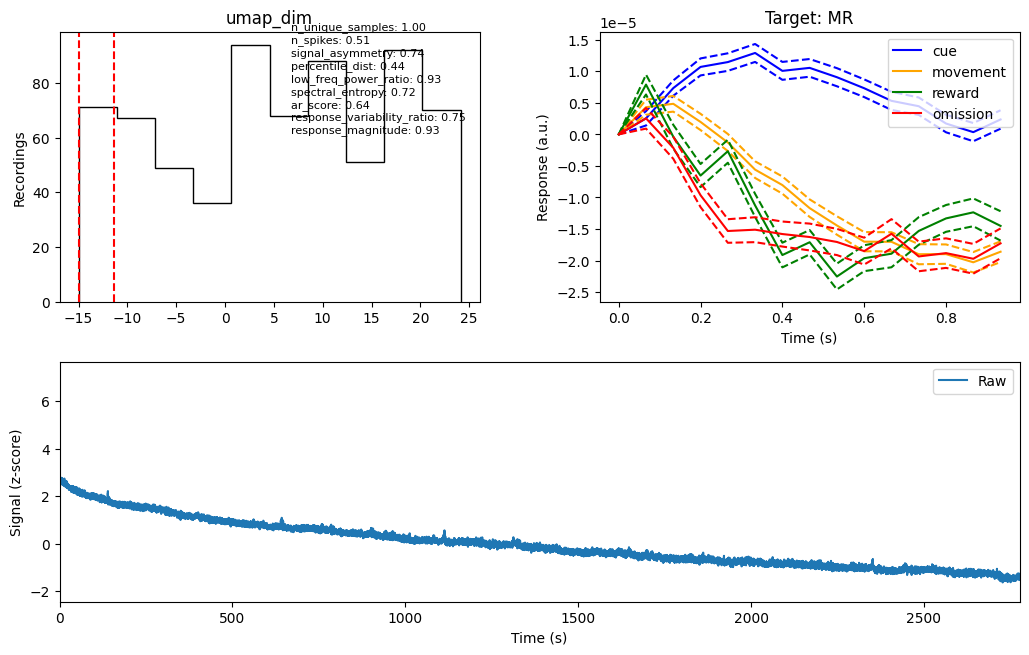

In [332]:
# Pick an event
metric = 'umap_dim'
fig, ax = plot_qc_example(df_metrics, metric, percentile_range=[0, 10]) 

In [237]:
df_metrics = df_metrics.dropna(subset=metrics_dict.keys())

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


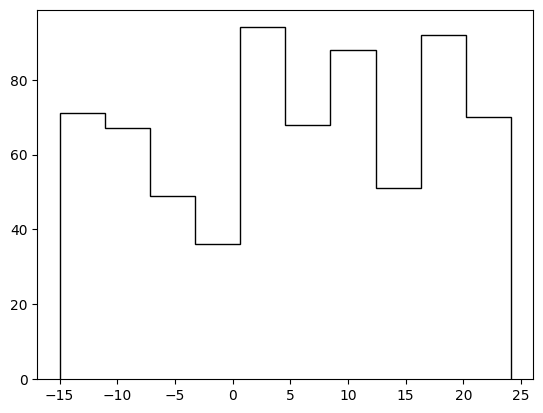

In [322]:
metrics_list = [
    'n_unique_samples',
    # 'n_spikes',
    'signal_asymmetry',
    'percentile_dist',
    'low_freq_power_ratio',
    # 'spectral_entropy',
    'ar_score',
    # 'response_variability_ratio',
    # 'response_magnitude'
    ]

X = df_metrics[metrics_list].values
X = quantile_transform(X, output_distribution='normal', n_quantiles=100)

n_components = 1  # 1, 2
dist = 'euclidean'  # 'euclidean', 'cosine'

umap = UMAP(n_components=n_components, metric=dist)
X_prime = umap.fit_transform(X)

fig, ax = plt.subplots()
if n_components == 2:
    ax.scatter(X_prime[:, 0], X_prime[:, 1], fc='none', ec='black')
elif n_components == 1:
    ax.hist(X_prime, histtype='step', color='black')

df_metrics = df_metrics.assign(umap_dim=X_prime[:, 0])

In [392]:
def plot_joint_distributions(df, metrics=None, transform=True, figsize=(10, 10), bins=30):
    """
    Plots joint distributions for each pair of metrics in the upper triangle of a grid.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the metrics as columns.
    metrics : list
        List of column names in `df` representing the metrics.
    figsize : tuple, optional
        Size of the figure. Default is (10, 10).
    bins : int, optional
        Number of bins for the histograms. Default is 30.

    Returns
    -------
    None
    """
    if metrics is None:
        metrics = df.columns
    n_metrics = len(metrics)

    X = df[metrics].dropna().values
    corr = df[metrics].dropna().corr(method='spearman')
    if transform:
        X = quantile_transform(X, output_distribution='normal', n_quantiles=500)
    
    fig, axs = plt.subplots(n_metrics, n_metrics, figsize=figsize)
    
    for i in range(n_metrics):
        for j in range(n_metrics):
            ax = axs[i, j]
            
            if i < j:  # Upper triangle: plot joint distributions
                x = X[:, j]
                y = X[:, i]
                ax.hist2d(x, y, bins=bins, cmap='Blues')
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)
                ax.set_xlabel(metrics[j] if i == n_metrics - 1 else "")
                ax.set_ylabel(metrics[i] if j == 0 else "")
                ax.text(0.3, 0.8, f'r={corr.iloc[i, j]:.2f}', transform=ax.transAxes)
            elif i == j:  # Diagonal: plot histograms
                data = X[:, i]
                ax.hist(data, bins=bins, color='gray', alpha=0.7)
                ax.set_xlabel(metrics[i])
            else:  # Lower triangle: turn off axes
                ax.axis("off")
    return fig, X

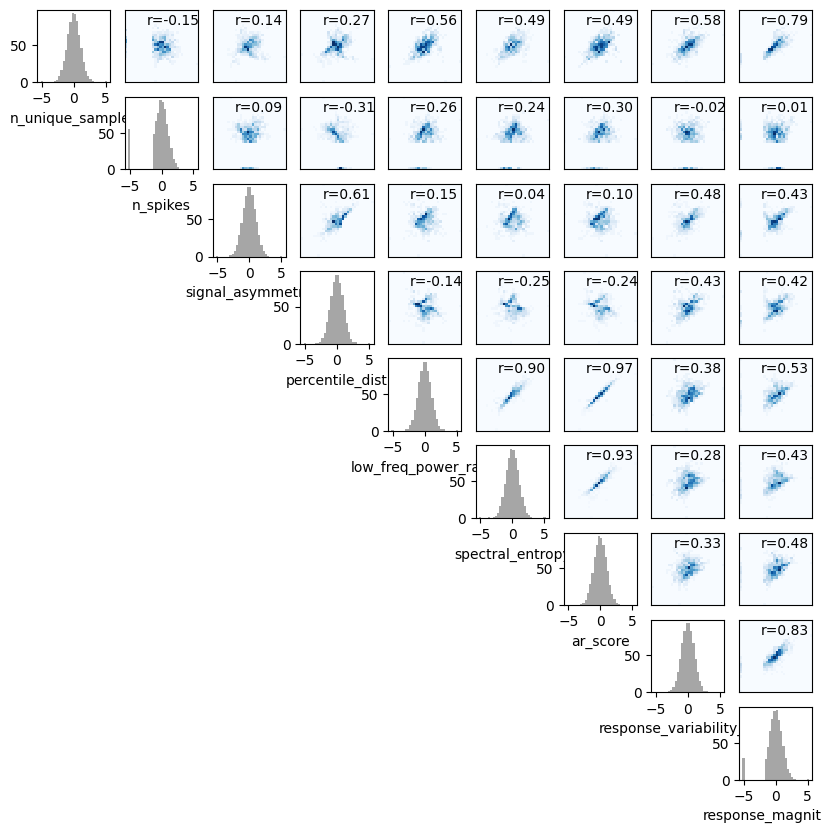

In [393]:
fig, X = plot_joint_distributions(df_metrics[metrics_dict.keys()])

,n_unique_samples,n_spikes,signal_asymmetry,percentile_dist,low_freq_power_ratio,spectral_entropy,ar_score,response_variability_ratio,response_magnitude
n_unique_samples,1.000000,-0.154467,0.138944,0.269289,0.556194,0.492490,0.489630,0.583728,0.794997
n_spikes,-0.154467,1.000000,0.088316,-0.311249,0.258841,0.238464,0.304242,-0.021240,0.009376
signal_asymmetry,0.138944,0.088316,1.000000,0.612764,0.150337,0.035894,0.098678,0.476866,0.431781
percentile_dist,0.269289,-0.311249,0.612764,1.000000,-0.143797,-0.250659,-0.239635,0.431901,0.415428
low_freq_power_ratio,0.556194,0.258841,0.150337,-0.143797,1.000000,0.902190,0.966302,0.384851,0.530546
spectral_entropy,0.492490,0.238464,0.035894,-0.250659,0.902190,1.000000,0.929756,0.283641,0.430927
ar_score,0.489630,0.304242,0.098678,-0.239635,0.966302,0.929756,1.000000,0.325709,0.475713
response_variability_ratio,0.583728,-0.021240,0.476866,0.431901,0.384851,0.283641,0.325709,1.000000,0.825666
response_magnitude,0.794997,0.009376,0.431781,0.415428,0.530546,0.430927,0.475713,0.825666,1.000000


In [364]:
from copulas.multivariate import GaussianMultivariate 

In [366]:
cop = GaussianMultivariate()

In [369]:
cop.fit(df_metrics[metrics_dict.keys()].dropna().values)

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6720: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWa

In [378]:
cop.sample?

Signature: cop.sample(num_rows=1, conditions=None)
Docstring:
Sample values from this model.

Argument:
    num_rows (int):
        Number of rows to sample.
    conditions (dict or pd.Series):
        Mapping of the column names and column values to condition on.

Returns:
    numpy.ndarray:
        Array of shape (n_samples, *) with values randomly
        sampled from this model distribution. If conditions have been
        given, the output array also contains the corresponding columns
        populated with the given values.

Raises:
    NotFittedError:
        if the model is not fitted.
File:      ~/miniconda3/envs/iblenv/lib/python3.10/site-packages/copulas/multivariate/gaussian.py
Type:      method

In [550]:
df_metrics['target'] = df_metrics['targeted_regions'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

In [551]:
df_metrics['target'].unique()

array(['DR', 'MR', 'VTA', 'SNc', 'LC', nan, 'NBM'], dtype=object)

Text(0.8, 0.9, 'Kruskal-Wallis: 6.24e+01\np=3.89e-12')

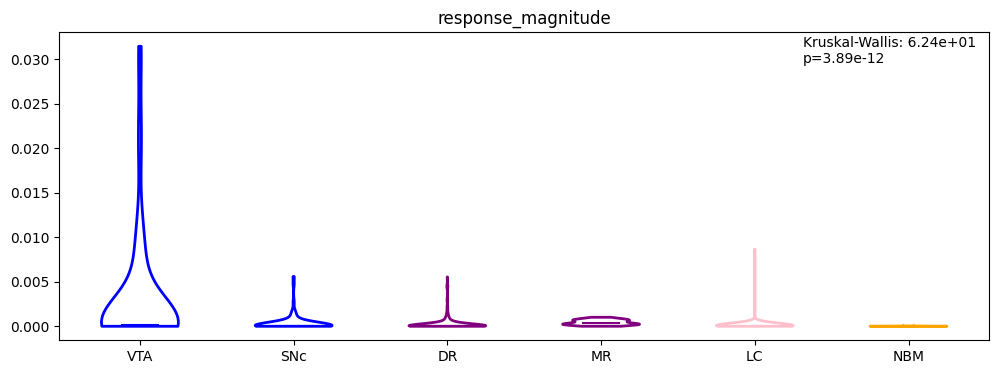

In [588]:
metric = 'response_magnitude'
target_order = {'VTA': 1, 'SNc': 2, 'DR': 3, 'MR': 4, 'LC': 5, 'NBM': 6}
target_colors = {'VTA': 'blue', 'SNc': 'blue', 'DR': 'purple', 'MR': 'purple', 'LC': 'pink', 'NBM': 'orange'}
    
fig, ax = plt.subplots(figsize=(12, 4))
for target, group in df_metrics.groupby('target'):
    violin_parts = ax.violinplot([group[metric]], positions=[target_order[target]], showextrema=False, showmedians=True)
    for pc in violin_parts['bodies']:
        pc.set_facecolor('none')
        pc.set_edgecolor(target_colors[target])
        pc.set_linewidth(2)
        pc.set_alpha(1)
        violin_parts['cmedians'].set_color(target_colors[target])
ax.set_xticks(np.arange(len(target_order)) + 1)
ax.set_xticklabels(target_order.keys())
ax.set_title(metric)

# Extract values for each group as lists
group_values = [group.tolist() for _, group in df_metrics.groupby('target')[metric]]
# Perform Kruskal-Wallis test
stat, p_value = stats.kruskal(*group_values)

ax.text(0.8, 0.9, f'Kruskal-Wallis: {stat:.2e}\np={p_value:.2e}', transform=ax.transAxes)

# df_metrics[metric]

In [401]:
df_metrics = df_metrics.sort_values(['subject', 'date'])

In [402]:
# Convert date column to datetime and compute 'recording_day'
df_metrics['date'] = pd.to_datetime(df_metrics['date'])  # Ensure 'date' column is datetime

def _get_recording_days(group):
    group = group.copy()  # avoid SettingWithCopyWarning
    # group['recording_day'] = (group['date'] - group['date'].iloc[0])
    group['recording_day'] = np.arange(len(group))
    return group

df_metrics = df_metrics.groupby('subject', group_keys=False).apply(_get_recording_days)
# df_metrics['recording_day'] = df_metrics['recording_day'].apply(lambda x: x.days)

/tmp/ipykernel_51833/315210523.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics = df_metrics.groupby('subject', group_keys=False).apply(_get_recording_days)


In [403]:
# Max days to look into the future
day_max = 21

# Initialize lists to hold results
index = []
data = {'rsquared': [], 'pvalue': [], 'slope': []}

# Loop over metrics
for metric in metrics_dict.keys():
    # Loop over days offset
    for day in range(1, day_max):
        # Filter the data to get values at day 0 and day
        df_day0 = df_metrics[df_metrics['recording_day'] == 0]
        df_day = df_metrics[df_metrics['recording_day'] == day]
        # Merge the data, ensuring paired samples for each subject
        merged = pd.merge(df_day0[['subject', metric]], df_day[['subject', metric]], on='subject', suffixes=('_0', f'_{day}'))
        # Linear regression
        if len(merged) < 3:
            continue
        res = stats.linregress(merged[f'{metric}_0'], merged[f'{metric}_{day}'])
        # Append results
        index.append((metric, day))
        data['rsquared'].append(res.rvalue ** 2)
        data['pvalue'].append(res.pvalue)
        data['slope'].append(res.slope)

# Create the DataFrame
multi_index = pd.MultiIndex.from_tuples(index, names=["metric", "day"])
df_pred = pd.DataFrame(data, index=multi_index)

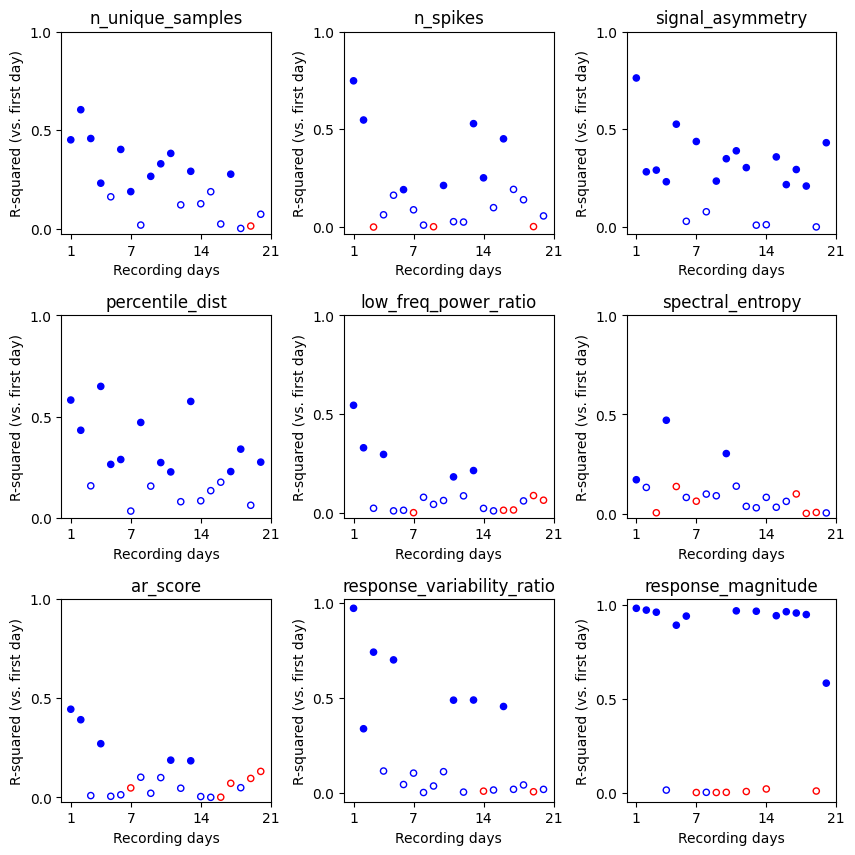

In [404]:
n_metrics = len(metrics_dict.keys())
fig, axs = plt.subplots(int(np.ceil(n_metrics / 3)), 3, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.35)

for ax, (metric, values) in zip(axs.ravel(), df_pred.groupby('metric', sort=False)):
    values = values.droplevel('metric').reset_index('day')
    ec = ['blue' if s > 0 else 'red' for s in values['slope']]
    fc = [c if p <= 0.05 else 'none' for c, p in zip(ec, values['pvalue'])]
    ax.scatter(values['day'], values['rsquared'], s=20, ec=ec, fc=fc)
    ax.set_title(metric)
    ax.set_xticks([1, 7, 14, 21])
    ax.set_xlabel('Recording days')
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylabel('R-squared (vs. first day)')

In [6]:
subject = 'ZFM-05235'